In [1]:
from qiskit import *
from qiskit import Aer
from qiskit.circuit.library.standard_gates import HGate
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.ticker as ticker
from qiskit.visualization import plot_state_city
from qiskit.providers.ibmq import least_busy
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
simulator = Aer.get_backend('statevector_simulator')
from qiskit import IBMQ, assemble, transpile
import qiskit.quantum_info as qi

provider = IBMQ.load_account()
provider.backends(simulator=False, operational=True)
small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
small_devices

[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [42]:
N = 4
qc = QuantumCircuit(4)
qr = QuantumRegister(4)

def Fgate(k):
    qcirc = QuantumCircuit(2,name="F_{:}".format(k))
    qcirc.rz(2*np.pi*k/N,1)
    qcirc.cx(1,0)
    qcirc.ch(0,1)
    qcirc.cx(1,0)
    qcirc.cz(1,0)
    return(qcirc.to_instruction())

def Fdgate(k):
    qcirc = QuantumCircuit(2,name="F+_{:}".format(k))
    qcirc.cz(1,0)
    qcirc.cx(1,0)
    qcirc.ch(0,1)
    qcirc.cx(1,0)
    qcirc.rz(-2*np.pi*k/N,1)
    return(qcirc.to_instruction())

def fSWAP():
    qcirc = QuantumCircuit(2,name="fSWAP")
    qcirc.cx(0,1)
    qcirc.cx(1,0)
    qcirc.cx(0,1)
    qcirc.h(1)
    qcirc.cx(0,1)
    qcirc.h(1)
    return(qcirc.to_instruction())

qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)

orderedlist = [["fd",0,1,1],["fd",2,3,0],["s",1,2],["fd",0,1,0],["fd",2,3,0],["s",1,2]]
for i in orderedlist:
    if(i[0] == "s" and len(i) == 3):
        qc.append(fSWAP(),[i[1],i[2]])
    elif(i[0] == "f" and len(i) == 4):
        qc.append(Fgate(i[3]),[i[1],i[2]])
    elif(i[0] == "fd" and len(i) == 4):
        qc.append(Fdgate(i[3]),[i[1],i[2]])
    else:
        print("Failed circuit instruction: {:}".format(i))
#print(qi.Operator(Fdgate(0)))
#print(qi.Operator(Fdgate(.5)))
qc.draw()

┌───┐┌───────┐          ┌───────┐          
q_0: ┤ X ├┤0      ├──────────┤0      ├──────────
     ├───┤│  F+_1 │┌────────┐│  F+_0 │┌────────┐
q_1: ┤ X ├┤1      ├┤0       ├┤1      ├┤0       ├
     ├───┤├───────┤│  fSWAP │├───────┤│  fSWAP │
q_2: ┤ X ├┤0      ├┤1       ├┤0      ├┤1       ├
     ├───┤│  F+_0 │└────────┘│  F+_0 │└────────┘
q_3: ┤ X ├┤1      ├──────────┤1      ├──────────
     └───┘└───────┘          └───────┘

## Run on a Simulator

In [43]:
job = execute(qc, simulator)

[ 0.-0.j  0.+0.j -0.-0.j  0.+0.j  0.+0.j -0.-0.j -0.+0.j -0.+0.j -0.+0.j
  0.-0.j -0.-0.j  0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.-1.j]


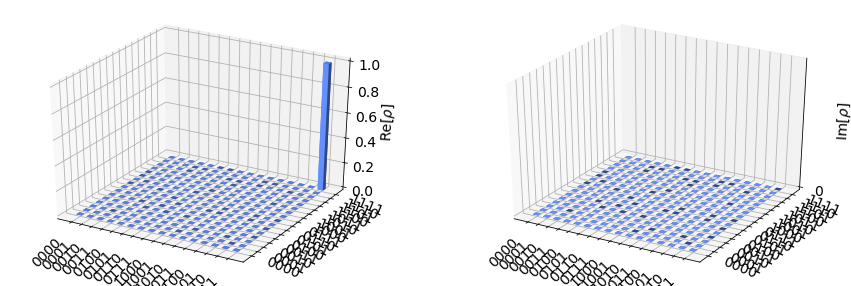

In [44]:
result=job.result()
outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)
plot_state_city(outputstate)

## Run on an actual device

In [95]:
N = 4
qcirc = QuantumCircuit(2)
qr = QuantumRegister(2)
qcirc.cz(0,1)
qcirc.cx(0,1)
qcirc.ch(1,0)
qcirc.cx(0,1)
qcirc.rz(2*np.pi*.5/N,0)

qcirc.draw()
print(qi.Operator(qcirc))
qcirc.draw()

Operator([[ 1.        +0.j        ,  0.        +0.j        ,
            0.        +0.j        ,  0.        +0.j        ],
          [ 0.        +0.j        , -0.5       -0.5j       ,
            0.5       +0.5j       ,  0.        +0.j        ],
          [ 0.        +0.j        ,  0.70710678+0.j        ,
            0.70710678+0.j        ,  0.        +0.j        ],
          [ 0.        +0.j        ,  0.        +0.j        ,
            0.        +0.j        , -0.70710678-0.70710678j]],
         input_dims=(2, 2), output_dims=(2, 2))


┌───┐     ┌──────────┐
q_0: ─■───■──┤ H ├──■──┤ RZ(pi/4) ├
      │ ┌─┴─┐└─┬─┘┌─┴─┐└──────────┘
q_1: ─■─┤ X ├──■──┤ X ├────────────
        └───┘     └───┘

In [96]:
job = execute(qcirc, simulator)

[1.-0.j 0.+0.j 0.+0.j 0.-0.j]


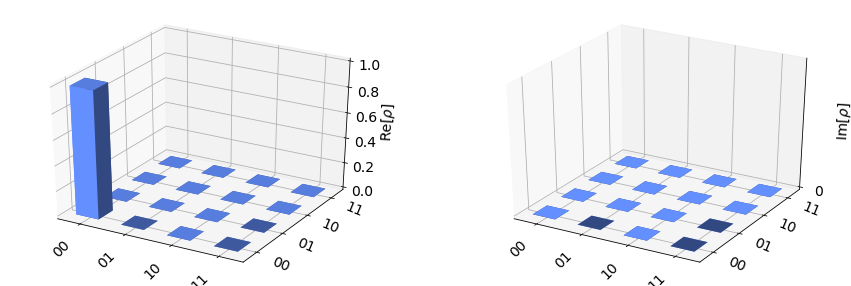

In [99]:
result=job.result()
outputstate = result.get_statevector(qcirc, decimals=3)
print(outputstate)
plot_state_city(outputstate)
#print(result.get_unitary(qcirc,decimals=3))

In [7]:
N = 4
qcirc = QuantumCircuit(2)
qr = QuantumRegister(2)
qcirc.cx(0,1)
qcirc.ch(1,0)
qcirc.cx(0,1)
qcirc.cz(0,1)
print(qi.Operator(qcirc))

Operator([[ 1.        +0.j,  0.        +0.j,  0.        +0.j,
            0.        +0.j],
          [ 0.        +0.j, -0.70710678+0.j,  0.70710678+0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.70710678+0.j,  0.70710678+0.j,
            0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
           -1.        +0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [12]:
N = 4
qcirc = QuantumCircuit(2)
qr = QuantumRegister(2)
qcirc.rz(2*np.pi/N,1)
qcirc.cx(1,0)
qcirc.ch(0,1)
qcirc.cx(1,0)
qcirc.cz(1,0)
print(qi.Operator(qcirc))

Operator([[ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
            0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
          [ 0.00000000e+00+0.j        ,  7.07106781e-01+0.j        ,
            4.32978028e-17+0.70710678j,  0.00000000e+00+0.j        ],
          [ 0.00000000e+00+0.j        ,  7.07106781e-01+0.j        ,
           -4.32978028e-17-0.70710678j,  0.00000000e+00+0.j        ],
          [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
            0.00000000e+00+0.j        , -6.12323400e-17-1.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


In [40]:
qcirc = QuantumCircuit(2)
qr = QuantumRegister(2)


qcirc.append(Fgate(1),[0,1])
qcirc.append(Fdgate(1),[0,1])
print(qi.Operator(qcirc))
qcirc.draw()

Operator([[1.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j,
           0.+0.00000000e+00j],
          [0.+0.00000000e+00j, 1.+0.00000000e+00j, 0.+0.00000000e+00j,
           0.+0.00000000e+00j],
          [0.+0.00000000e+00j, 0.+0.00000000e+00j, 1.+1.23259516e-32j,
           0.+0.00000000e+00j],
          [0.+0.00000000e+00j, 0.+0.00000000e+00j, 0.+0.00000000e+00j,
           1.+0.00000000e+00j]],
         input_dims=(2, 2), output_dims=(2, 2))


┌──────┐┌───────┐
q_0: ┤0     ├┤0      ├
     │  F_1 ││  F+_1 │
q_1: ┤1     ├┤1      ├
     └──────┘└───────┘

In [41]:
qcirc = QuantumCircuit(2)
qr = QuantumRegister(2)
qcirc.append(Fdgate(1),[0,1])
print(qi.Operator(qcirc))
qcirc.draw()

Operator([[ 1.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
            0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ],
          [ 0.00000000e+00+0.j        ,  7.07106781e-01+0.j        ,
            7.07106781e-01+0.j        ,  0.00000000e+00+0.j        ],
          [ 0.00000000e+00+0.j        ,  4.32978028e-17-0.70710678j,
           -4.32978028e-17+0.70710678j,  0.00000000e+00+0.j        ],
          [ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
            0.00000000e+00+0.j        , -6.12323400e-17+1.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


┌───────┐
q_0: ┤0      ├
     │  F+_1 │
q_1: ┤1      ├
     └───────┘